In [1]:
# Imports
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import statsmodels.api as sm
from statsmodels.api import OLS
import seaborn as sns
plt.style.use('seaborn-notebook')
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

# Remove warnings for readability
import warnings
warnings.filterwarnings("ignore")

In [2]:
# initialize dataframe
kc_house = pd.read_csv('./data/kc_house_data.csv', parse_dates=['date']) 

In [3]:
# check first 5 rows
kc_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
# check for columns/datatypes
kc_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  object        
 9   view           21534 non-null  object        
 10  condition      21597 non-null  object        
 11  grade          21597 non-null  object        
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  object        
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

__Objects__: 'waterfront', 'view', 'condition', 'grade', 'sqft_basement' - 'sqft_basement' seems like it should be numeric based on the data from the head, while the others may need to be transformed later to categorical variables

### Duplicates

In [5]:
# check for duplicate ids
kc_house['id'].duplicated().sum()

177

In [6]:
# drop duplicates, keeping first
kc_house = kc_house.sort_values('id', ascending = False).drop_duplicates(subset = 'id', keep = 'first')

In [7]:
# check duplicate count
kc_house['id'].duplicated().sum()

0

In [8]:
# drop 'id' - no longer useful as we have handled duplicate values
kc_house = kc_house.drop('id', axis=1)

### Nulls

In [9]:
# check null values
kc_house.isnull().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2351
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3807
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

#### waterfront

In [10]:
kc_house['waterfront'].value_counts()

NO     18923
YES      146
Name: waterfront, dtype: int64

In [11]:
# fill nulls with 0 or NO as the overwhelming majority of the sample is NO
kc_house['waterfront'] = kc_house['waterfront'].fillna('NO')

#### view

In [12]:
kc_house['view'].value_counts()

NONE         19253
AVERAGE        956
GOOD           505
FAIR           329
EXCELLENT      314
Name: view, dtype: int64

In [13]:
# vast majority of data set has NONE, filling nulls with NONE
kc_house['view'] = kc_house['view'].fillna('NONE')

#### yr_renovated

In [14]:
kc_house['yr_renovated'].value_counts()

0.0       16873
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1971.0        1
1944.0        1
1951.0        1
1950.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [15]:
# vast majority of data has 0, fill w/ 0
kc_house['yr_renovated'] = kc_house['yr_renovated'].fillna(0)

In [16]:
# Final check for null values
kc_house.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Datatypes

In [17]:
# values of sqft_basement
kc_house['sqft_basement'].value_counts()

0.0       12717
?           452
600.0       216
500.0       206
700.0       205
          ...  
176.0         1
3480.0        1
1990.0        1
652.0         1
875.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [18]:
# sqft_basement should be able to be calculated by taking sqft_living (overall) - sqft_above (only above basement)
# we should replace missing values of sqft_basement with these calculated values
for index in list(kc_house[kc_house['sqft_basement'] == '?'].index.values):
    kc_house.loc[index, 'sqft_basement'] = kc_house.loc[index, 'sqft_living'] - kc_house.loc[index, 'sqft_above']

In [19]:
# verify that there are no more sqft_basement values '?'
kc_house[kc_house['sqft_basement'] == '?']

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [20]:
# cast as float
kc_house['sqft_basement'] = kc_house['sqft_basement'].astype(float)

In [21]:
#verify
kc_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 15937 to 2495
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21420 non-null  datetime64[ns]
 1   price          21420 non-null  float64       
 2   bedrooms       21420 non-null  int64         
 3   bathrooms      21420 non-null  float64       
 4   sqft_living    21420 non-null  int64         
 5   sqft_lot       21420 non-null  int64         
 6   floors         21420 non-null  float64       
 7   waterfront     21420 non-null  object        
 8   view           21420 non-null  object        
 9   condition      21420 non-null  object        
 10  grade          21420 non-null  object        
 11  sqft_above     21420 non-null  int64         
 12  sqft_basement  21420 non-null  float64       
 13  yr_built       21420 non-null  int64         
 14  yr_renovated   21420 non-null  float64       
 15  zipcode        2

### Remaining Extraneous Columns

In [22]:
# date is not relevant to our analysis
kc_house.drop('date',axis=1,inplace=True)

### Categorical Variables

In [23]:
kc_house.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15937,268950.0,3,1.00,1320,8100,1.0,NO,NONE,Average,6 Low Average,880,440.0,1943,0.0,98166,47.4697,-122.351,1000,8100
20963,399900.0,2,1.75,1410,1005,1.5,NO,NONE,Average,9 Better,900,510.0,2011,0.0,98027,47.5446,-122.018,1440,1188
7614,339000.0,3,1.00,1100,4128,1.0,NO,NONE,Good,7 Average,720,380.0,1942,0.0,98126,47.5296,-122.379,1510,4538
3257,380000.0,2,1.00,1040,7372,1.0,NO,NONE,Very Good,7 Average,840,200.0,1939,0.0,98126,47.5285,-122.378,1930,5150
16723,365000.0,5,2.00,1600,4168,1.5,NO,NONE,Average,7 Average,1600,0.0,1927,0.0,98126,47.5297,-122.381,1190,4168


#### waterfront

In [24]:
kc_house['waterfront'].value_counts()

NO     21274
YES      146
Name: waterfront, dtype: int64

In [25]:
# map 1 to YES and 0 to NO
waterfront_dict = {'YES':1, 'NO':0}
kc_house['waterfront'] = kc_house['waterfront'].map(waterfront_dict)

In [26]:
kc_house['waterfront'].value_counts()

0    21274
1      146
Name: waterfront, dtype: int64

#### view

In [27]:
kc_house['view'].value_counts()

NONE         19316
AVERAGE        956
GOOD           505
FAIR           329
EXCELLENT      314
Name: view, dtype: int64

In [28]:
view_dict = {'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1}
kc_house['view'] = kc_house['view'].map(view_dict)

In [29]:
kc_house['view'].value_counts()

1    19316
3      956
4      505
2      329
5      314
Name: view, dtype: int64

#### condition

In [30]:
kc_house['condition'].value_counts()

Average      13900
Good          5643
Very Good     1687
Fair           162
Poor            28
Name: condition, dtype: int64

In [31]:
condition_dict = {'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1}
kc_house['condition'] = kc_house['condition'].map(condition_dict)

In [32]:
kc_house['condition'].value_counts()

3    13900
4     5643
5     1687
2      162
1       28
Name: condition, dtype: int64

#### grade 

In [33]:
kc_house['grade'].value_counts()

7 Average        8889
8 Good           6041
9 Better         2606
6 Low Average    1995
10 Very Good     1130
11 Excellent      396
5 Fair            234
12 Luxury          88
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [34]:
grade_dict = {'13 Mansion':11, '12 Luxury':10, '11 Excellent':9, '10 Very Good':8, '9 Better': 7, '8 Good': 6, 
              '7 Average': 5, '5 Fair': 4, '6 Low Average': 3, '4 Low': 2, '3 Poor': 1}
kc_house['grade'] = kc_house['grade'].map(grade_dict)

In [35]:
kc_house['grade'].value_counts()

5     8889
6     6041
7     2606
3     1995
8     1130
9      396
4      234
10      88
2       27
11      13
1        1
Name: grade, dtype: int64

#### zipcodes

In [36]:
kc_house['zipcode'].value_counts()

98103    600
98038    586
98115    576
98052    571
98117    548
        ... 
98102    104
98010     99
98024     79
98148     56
98039     49
Name: zipcode, Length: 70, dtype: int64

Create buckets of zipcodes based on the zipcode map from KC Website (https://www.kingcounty.gov/services/gis/Maps/vmc/Boundaries.aspx)

- 1 - Seattle, Shoreline, Lake Forest Park

- 2 - Kirkland, Kenmore, Bothell, Redmond, Woodinville

- 3 - Bellevue, Mercer Island, Newcastle

- 4 - Renton, Kent

- 5 - Burien, Normandy Park, Des Moines, SeaTac, Tukwilla, Vashon Island

- 6 - Federal Way, Auburn, Algona, Milton, Pacific

- 7 - Sammamish, Issaquah, Carnation, Duvall

- 8 - Covington, Maple Valley, Black Diamond, Enumclaw

- 9 - Snoquaimie, North Bend

In [37]:
# Seattle, Shoreline, Lake Forest Park
zip_1 = [98177, 98133, 98125, 98155, 98107, 98115, 98105, 98109, 98112,
        98117, 98199, 98122, 98144, 98118, 98108, 98106, 98136, 98126,
        98116, 98102, 98103, 98119, 98134]

# Kirkland, Kenmore, Bothell, Redmond, Woodinville
zip_2 = [98053, 98052, 98077, 98072, 98033, 98034, 98011, 98028]

# Bellevue, Medina, Mercer Island, Newcastle
zip_3 = [98059, 98056, 98006, 98040, 98008, 98007, 98005, 98004, 98039]

# Renton, Kent
zip_4 = [98057, 98055, 98058, 98032, 98031, 98030, 98178]

# Burien, Normandy Park, Des Moines, SeaTac, Tukwilla, Vashon Island
zip_5 = [98070, 98146, 98168, 98166, 98198, 98148, 98158, 98188]

# Federal Way, Auburn, Algona, Milton, Pacific
zip_6 = [98023, 98003, 98063, 98047, 98001, 98002, 98093, 98071, 98002, 98092]

# Sammamish, Issaquah, Carnation, Duvall
zip_7 = [98074, 98075, 98029, 98027, 98019, 98014]

# Covington, Maple Valley, Black Diamond, Enumclaw
zip_8 = [98022, 98042, 98010, 98038, 98051]

# Snoquaimie, North Bend
zip_9 = [98065, 98045, 98024]

In [38]:
def zipcode(x):
    
    '''Parameters:
           x (int): The property's zip code.
       Returns:
           zipcode group (str): The property's area group (a letter from A to I)
           Will return X if zip code not recognised.'''
    
    if x in zip_1:
        return 1
    elif x in zip_2:
        return 2
    elif x in zip_3:
        return 3
    elif x in zip_4:
        return 4
    elif x in zip_5:
        return 5
    elif x in zip_6:
        return 6
    elif x in zip_7:
        return 7
    elif x in zip_8:
        return 8
    elif x in zip_9:
        return 9
    else:
        return 10

In [39]:
#one hot encoding our zipcode
kc_house['zip_group'] = kc_house['zipcode'].map(zipcode)
zip_dummies = pd.get_dummies(kc_house["zip_group"], prefix="zip", drop_first=True)

#merge with our dataframe
kc_house = pd.concat([kc_house, zip_dummies], axis=1)

#review
kc_house.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,zip_group,zip_2,zip_3,zip_4,zip_5,zip_6,zip_7,zip_8,zip_9
15937,268950.0,3,1.00,1320,8100,1.0,0,1,3,3,...,8100,5,0,0,0,1,0,0,0,0
20963,399900.0,2,1.75,1410,1005,1.5,0,1,3,7,...,1188,7,0,0,0,0,0,1,0,0
7614,339000.0,3,1.00,1100,4128,1.0,0,1,4,5,...,4538,1,0,0,0,0,0,0,0,0
3257,380000.0,2,1.00,1040,7372,1.0,0,1,5,5,...,5150,1,0,0,0,0,0,0,0,0
16723,365000.0,5,2.00,1600,4168,1.5,0,1,3,5,...,4168,1,0,0,0,0,0,0,0,0


### Outliers

In [40]:
kc_house.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,zip_group,zip_2,zip_3,zip_4,zip_5,zip_6,zip_7,zip_8,zip_9
count,2.142000e+04,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,...,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000
mean,5.412725e+05,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,0.006816,1.233987,3.410784,5.580579,...,12775.718161,3.469234,0.134874,0.121148,0.075444,0.064286,0.078151,0.085761,0.068347,0.028105
std,3.677194e+05,0.925405,0.768720,918.808412,4.153080e+04,0.540081,0.082280,0.765437,0.650035,1.312399,...,27345.621867,2.533594,0.341597,0.326307,0.264112,0.245267,0.268416,0.280017,0.252347,0.165275
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,1.000000,1.000000,...,651.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.237250e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,1.000000,3.000000,5.000000,...,5100.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,0.000000,1.000000,3.000000,5.000000,...,7620.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,0.000000,1.000000,4.000000,6.000000,...,10086.250000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,5.000000,11.000000,...,871200.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
# calculate 25, 75, iqr, whiskers for 'price'
price_q75, price_q25 = np.percentile(kc_house['price'], [75, 25])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -158187.5 
price_max: 1126912.5


In [42]:
# apply min, max filters to remove outliers
kc_house = kc_house[kc_house['price'] >= price_min]
kc_house = kc_house[kc_house['price'] <= price_max]

### Multicollinearity

In [43]:
kc_house.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,zip_group,zip_2,zip_3,zip_4,zip_5,zip_6,zip_7,zip_8,zip_9
price,1.000000,0.294950,0.454418,0.621337,0.093345,0.271706,0.048987,0.236227,0.036171,0.606839,...,0.082141,-0.233956,0.176938,0.194129,-0.234451,-0.185902,-0.270465,0.176944,-0.183944,0.002822
bedrooms,0.294950,1.000000,0.491353,0.585254,0.024493,0.154741,-0.025951,0.036679,0.024029,0.328172,...,0.021643,0.099486,0.057043,0.125916,0.029418,-0.049787,0.027249,0.065140,0.011938,0.011055
bathrooms,0.454418,0.491353,1.000000,0.716210,0.064589,0.501777,-0.005581,0.094724,-0.140126,0.615025,...,0.064676,0.159236,0.103117,0.065563,-0.020462,-0.124366,0.002814,0.173964,0.050095,0.063189
sqft_living,0.621337,0.585254,0.716210,1.000000,0.158762,0.338971,0.000661,0.166361,-0.075222,0.684498,...,0.172870,0.175740,0.132804,0.118604,-0.030783,-0.087718,-0.005843,0.190243,0.019484,0.071454
sqft_lot,0.093345,0.024493,0.064589,0.158762,1.000000,-0.017611,0.025070,0.079396,-0.002928,0.087641,...,0.708766,0.196800,0.031298,-0.021694,-0.013116,0.022328,0.008070,0.082177,0.123293,0.090610
floors,0.271706,0.154741,0.501777,0.338971,-0.017611,1.000000,-0.006136,-0.015689,-0.280975,0.446518,...,-0.021833,0.065141,0.005828,-0.054087,-0.058895,-0.123589,-0.040296,0.151931,0.045483,0.063930
waterfront,0.048987,-0.025951,-0.005581,0.000661,0.025070,-0.006136,1.000000,0.273983,0.010973,-0.012314,...,0.030997,0.023580,-0.019903,-0.013979,0.014342,0.132114,-0.007900,-0.011996,-0.013998,-0.008681
view,0.236227,0.036679,0.094724,0.166361,0.079396,-0.015689,0.273983,1.000000,0.034078,0.122842,...,0.076761,-0.015090,-0.055241,-0.001709,-0.025128,0.094541,-0.025330,-0.030034,-0.018187,0.019070
condition,0.036171,0.024029,-0.140126,-0.075222,-0.002928,-0.280975,0.010973,0.034078,1.000000,-0.167358,...,0.001529,-0.079751,-0.054979,0.126534,0.002897,-0.004869,-0.002714,-0.097552,0.006861,-0.077641
grade,0.606839,0.328172,0.615025,0.684498,0.087641,0.446518,-0.012314,0.122842,-0.167358,1.000000,...,0.095449,0.094990,0.136781,0.107376,-0.063217,-0.159251,-0.014059,0.213741,-0.019172,0.025464


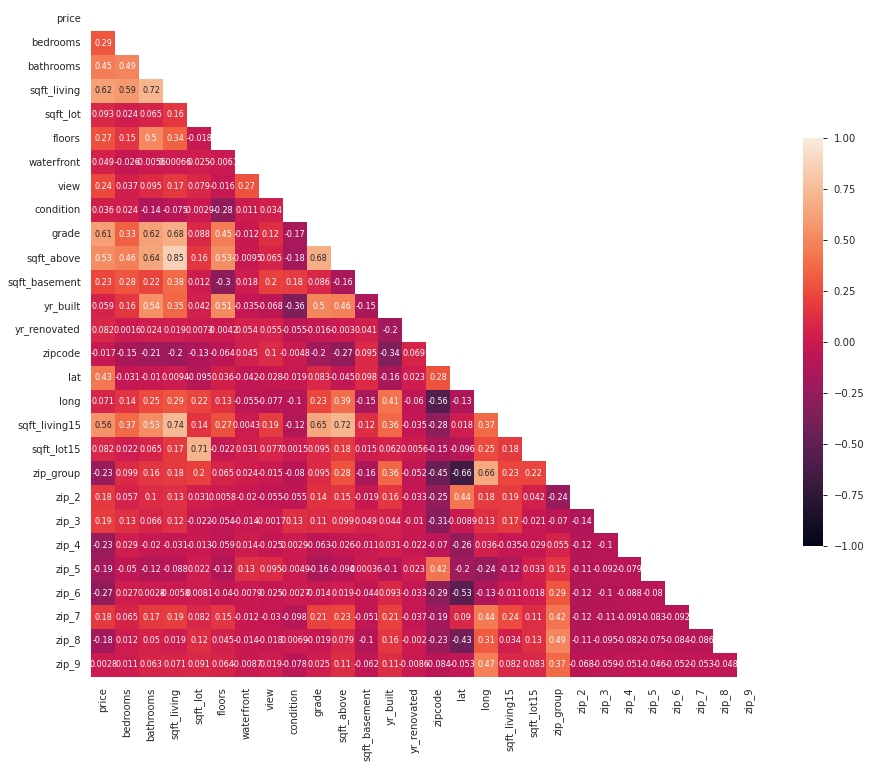

In [44]:
mask = np.zeros_like(kc_house.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (15, 15))
    ax = sns.heatmap(kc_house.corr(), 
                     annot = True,
                     annot_kws={"size": 8},
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)


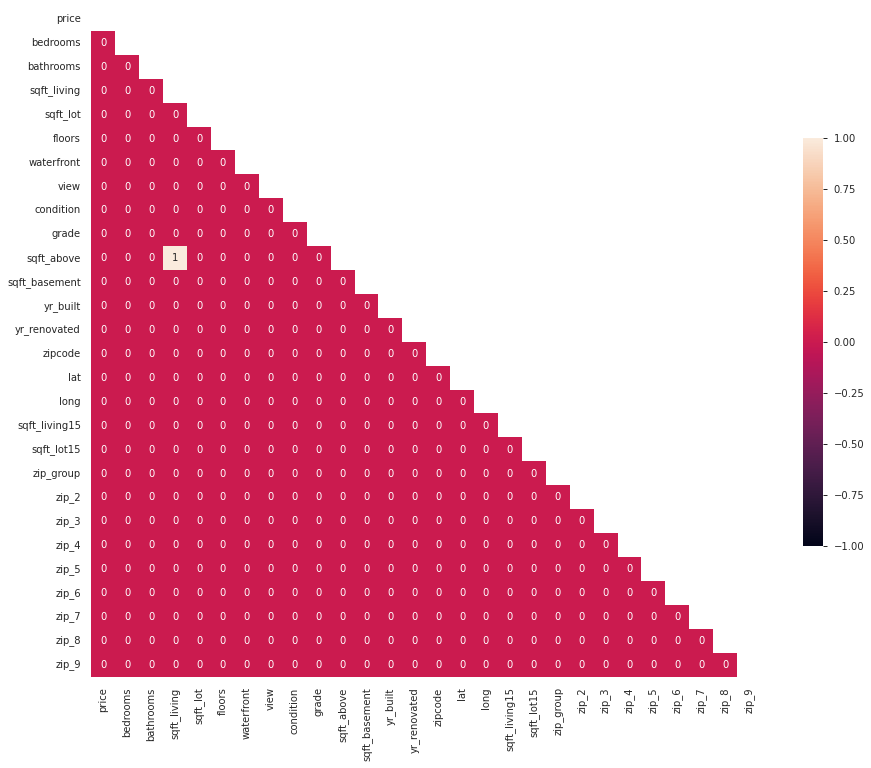

In [45]:
#check for multicollinearity by highlighting corr coefs of greater than 0.75 to each other
mask = np.zeros_like(abs(kc_house.corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize = (15, 15))
    ax = sns.heatmap(abs(kc_house.corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)


In [46]:
# drop above since sqft_living has higher corr with price
kc_house.drop('sqft_above', axis=1, inplace=True)

In [47]:
kc_house.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.621337
grade            0.606839
sqft_living15    0.561914
bathrooms        0.454418
lat              0.430432
bedrooms         0.294950
floors           0.271706
zip_6            0.270465
view             0.236227
zip_4            0.234451
sqft_basement    0.234129
zip_group        0.233956
zip_3            0.194129
zip_5            0.185902
zip_8            0.183944
zip_7            0.176944
zip_2            0.176938
sqft_lot         0.093345
sqft_lot15       0.082141
yr_renovated     0.081785
long             0.070797
yr_built         0.058868
waterfront       0.048987
condition        0.036171
zipcode          0.017345
zip_9            0.002822
Name: price, dtype: float64

In [48]:
# OLS model
y = kc_house['price']
X_baseline = kc_house[['sqft_living', 'grade', 'sqft_living15', 'bathrooms', 'lat', 'bedrooms', 'floors', 'zip_6',
                          'view', 'zip_4', 'sqft_basement', 'zip_3']]
model = sm.OLS(y, sm.add_constant(X_baseline)).fit()
model_summary = model.summary()

In [49]:
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3293.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:37:09   Log-Likelihood:            -2.6596e+05
No. Observations:               20269   AIC:                         5.319e+05
Df Residuals:                   20256   BIC:                         5.320e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.343e+07   3.72e+05    -62.929      0.000   -2.42e+07   -2.27e+07
sqft_living      96.0563      2.418     39.728      0.000      91.317     100.795
grade           4.33e+04   1111.631     38.950      0.000    4.11e+04    4.55e+04
sqft_living15    34.3755      2.252     15.265      0.000      29.961      38.790
bathrooms     -7359.0941   1948.659     -3.776      0.000   -1.12e+04   -3539.565
lat            4.919e+05   7829.705     62.826      0.000    4.77e+05    5.07e+05
bedrooms      -7162.2141   1196.498     -5.986      0.000   -9507.446   -4816.982
floors         7994.3650   2190.938      3.649      0.000    3699.948    1.23e+04
zip_6          -6.11e+04   3864.044    -15.814      0.000   -6.87e+04   -5.35e+04
view           4.287e+04   1384.992     30.953      0.000    4.02e+04    4.56e+04
zip_4         -8.374e+04   3440.852    -24.338      0.000   -9.05e+04    -7.7e+04
sqft_basement     9.2356      2.776      3.326      0.001       3.794      14.678
zip_3          6.573e+04   2909.854     22.590      0.000       6e+04    7.14e+04
==============================================================================
Omnibus:                     1934.892   Durbin-Watson:                   1.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3122.537
Skew:                           0.703   Prob(JB):                         0.00
Kurtosis:                       4.312   Cond. No.                     1.28e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
# clean, categorized dataset
kc_house.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,zip_group,zip_2,zip_3,zip_4,zip_5,zip_6,zip_7,zip_8,zip_9
15937,268950.0,3,1.00,1320,8100,1.0,0,1,3,3,...,8100,5,0,0,0,1,0,0,0,0
20963,399900.0,2,1.75,1410,1005,1.5,0,1,3,7,...,1188,7,0,0,0,0,0,1,0,0
7614,339000.0,3,1.00,1100,4128,1.0,0,1,4,5,...,4538,1,0,0,0,0,0,0,0,0
3257,380000.0,2,1.00,1040,7372,1.0,0,1,5,5,...,5150,1,0,0,0,0,0,0,0,0
16723,365000.0,5,2.00,1600,4168,1.5,0,1,3,5,...,4168,1,0,0,0,0,0,0,0,0


In [51]:
kc_house.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.621337
grade            0.606839
sqft_living15    0.561914
bathrooms        0.454418
lat              0.430432
bedrooms         0.294950
floors           0.271706
zip_6            0.270465
view             0.236227
zip_4            0.234451
sqft_basement    0.234129
zip_group        0.233956
zip_3            0.194129
zip_5            0.185902
zip_8            0.183944
zip_7            0.176944
zip_2            0.176938
sqft_lot         0.093345
sqft_lot15       0.082141
yr_renovated     0.081785
long             0.070797
yr_built         0.058868
waterfront       0.048987
condition        0.036171
zipcode          0.017345
zip_9            0.002822
Name: price, dtype: float64

In [52]:
corr_bar =   {'Category': ['Livable Sq. Ft.','Grade','Bathrooms','View','Bedrooms',
                          'Bellevue Area','Federal Way Area ','Kent Area','Covington Area','SeaTac Area'],
               'Correlation': [0.701651,0.635260,0.525859,0.392958,0.309665,0.269217,
                                    0.197907,0.176499,0.146567,0.138402]
              }
corr_bar_df = pd.DataFrame(corr_bar)

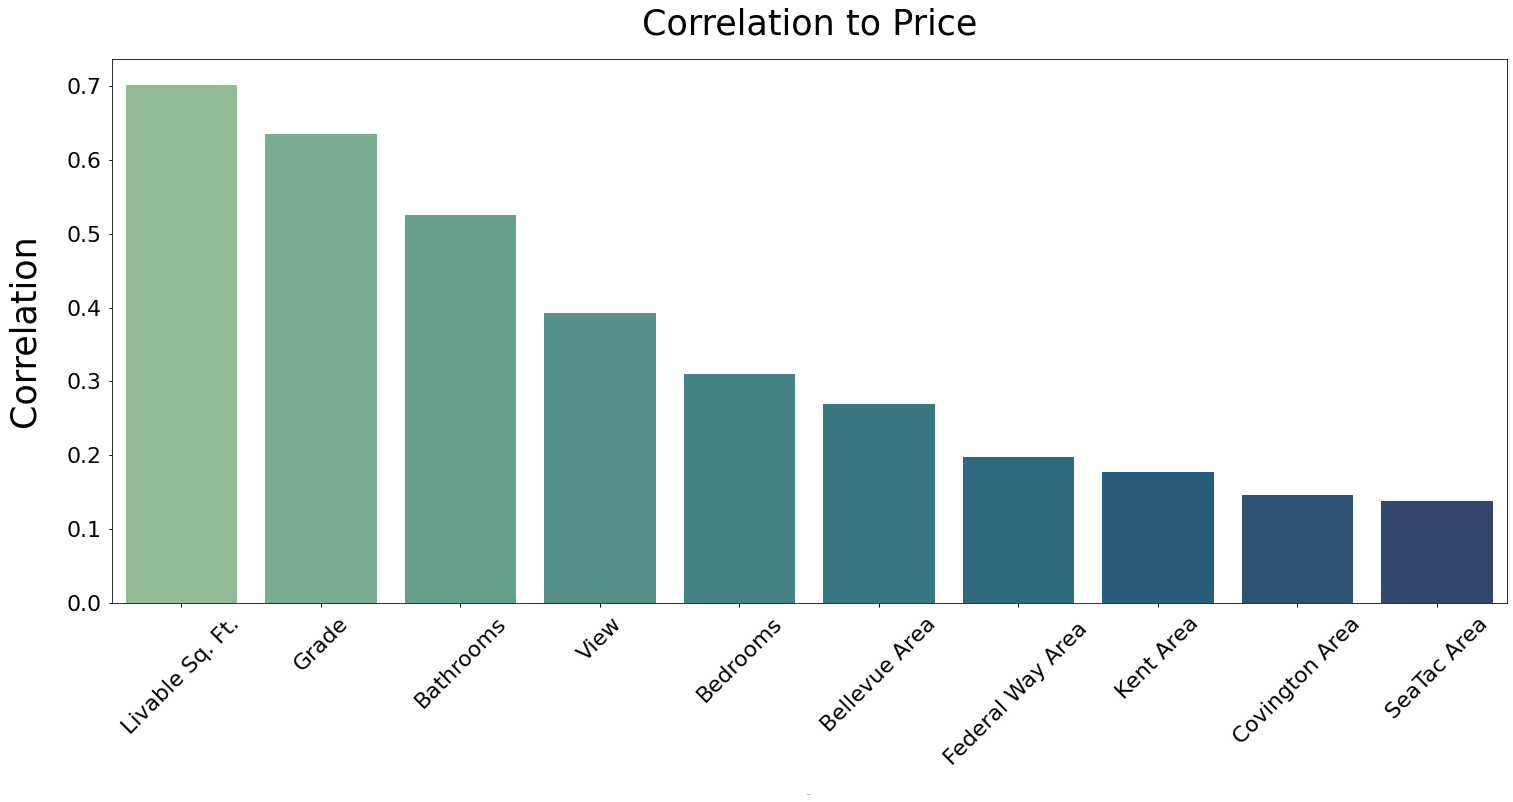

In [53]:
fig, ax = plt.subplots(figsize=(25,10))
ax.set_title('Correlation to Price', fontsize=35, pad=25)
ax.set_xlabel('Correlation', fontsize=0, labelpad=25)
ax.set_ylabel('Correlation', fontsize=35, labelpad=25)
plt.xticks(fontsize=22,rotation=45)
plt.yticks(fontsize=22)
sns.barplot(x='Category', y='Correlation', data=corr_bar_df, palette='crest')
fig.savefig('images/feature_corrcoef_bar');

In [54]:
kc_house.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,zip_group,zip_2,zip_3,zip_4,zip_5,zip_6,zip_7,zip_8,zip_9
15937,268950.0,3,1.00,1320,8100,1.0,0,1,3,3,...,8100,5,0,0,0,1,0,0,0,0
20963,399900.0,2,1.75,1410,1005,1.5,0,1,3,7,...,1188,7,0,0,0,0,0,1,0,0
7614,339000.0,3,1.00,1100,4128,1.0,0,1,4,5,...,4538,1,0,0,0,0,0,0,0,0
3257,380000.0,2,1.00,1040,7372,1.0,0,1,5,5,...,5150,1,0,0,0,0,0,0,0,0
16723,365000.0,5,2.00,1600,4168,1.5,0,1,3,5,...,4168,1,0,0,0,0,0,0,0,0


In [55]:
zip_group_df = kc_house.groupby(['zip_group']).mean().reset_index()

In [56]:
zip_group_df

,zip_group,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_living15,sqft_lot15,zip_2,zip_3,zip_4,zip_5,zip_6,zip_7,zip_8,zip_9
0,1,514892.083766,3.107699,1.863394,1705.050461,5403.531286,1.488754,0.000288,1.209054,3.445502,...,1626.720877,5306.614908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,570249.652854,3.462014,2.239004,2237.400218,17792.013086,1.485278,0.000000,1.083242,3.318066,...,2212.733188,15272.832425,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,595293.674976,3.665099,2.190263,2246.189087,12077.142051,1.392521,0.000470,1.169332,3.646754,...,2236.370179,10853.066322,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,311967.962802,3.422195,2.004960,1896.792312,12830.526348,1.369808,0.004960,1.117793,3.414135,...,1849.876007,9801.967142,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,333652.439383,3.163115,1.725386,1724.665687,17962.451874,1.229978,0.027186,1.398237,3.396032,...,1645.763409,15685.114622,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,6,290231.689593,3.413876,2.061005,1962.776316,15701.840311,1.405203,0.001196,1.118421,3.401914,...,1900.517344,14066.938397,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,7,596650.052811,3.522998,2.454571,2455.496877,25316.729131,1.741908,0.000568,1.110165,3.203294,...,2410.914253,22113.367405,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,8,340490.129363,3.370294,2.181896,2032.007529,32380.780287,1.565024,0.000000,1.130732,3.423682,...,1998.427105,24616.114305,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,9,480924.976190,3.389456,2.313776,2298.010204,35666.656463,1.676020,0.000000,1.243197,3.117347,...,2214.551020,25180.729592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.,
        700000.]),
 [Text(0, 0.0, '0'),
  Text(0, 100000.0, '100000'),
  Text(0, 200000.0, '200000'),
  Text(0, 300000.0, '300000'),
  Text(0, 400000.0, '400000'),
  Text(0, 500000.0, '500000'),
  Text(0, 600000.0, '600000'),
  Text(0, 700000.0, '700000')])

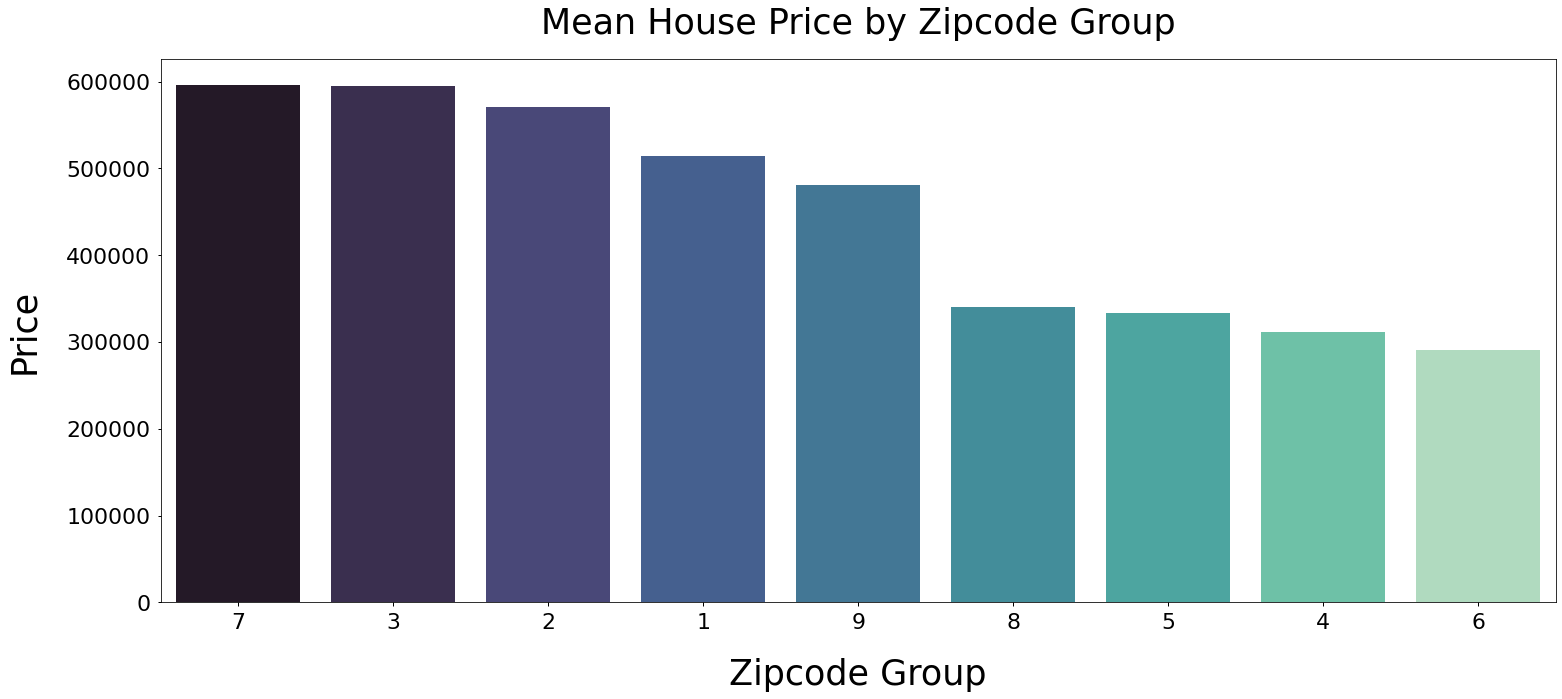

In [57]:
fig, ax = plt.subplots(figsize=(25,10))

sns.barplot(x='zip_group', y='price', data=zip_group_df, palette='mako',order=zip_group_df.sort_values('price', ascending=False).zip_group)
fig.savefig('images/zip_group_chart');

ax.set_title('Mean House Price by Zipcode Group', fontsize=35, pad=25)
ax.set_xlabel('Zipcode Group', fontsize=35, labelpad=25)
ax.set_ylabel('Price', fontsize=35, labelpad=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

### Models

#### Helper Functions
- __ohe__ used for setup of categorical data
- __scale_score__ used to standardize the scale of values in test/train data and score the standardized results to get more interpretable R-squared values
- __get_train_test_metrics__ used to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RSME) for regression analysis

In [ ]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="error")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

In [ ]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_preds)}
    test score: {r2_score(y_test, test_preds)}""")
    
    return X_train_scaled, X_test_scaled, train_preds, test_preds

In [ ]:
def get_train_test_metrics(y_train, train_preds,
               y_test, test_preds):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

In [ ]:
y = kc_house['price']
X = kc_house.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

#### Baseline

In [ ]:
cols = ['sqft_living'] 

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

#### Model 2

In [ ]:
cols = ['sqft_living','grade'] 

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

#### Model 3

In [ ]:
cols = ['sqft_living','grade','view'] 

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

#### Model 4

In [ ]:
cols = ['sqft_living','grade','view','bathrooms'] 

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

#### Model 5 - Best Model

In [ ]:
cols = ['sqft_living','grade','view','zip_group'] 

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

#### Model 6

In [ ]:
cols = ['sqft_living','grade','view','zip_group','bathrooms'] 

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

Very marginal improvement with bathrooms added suggests that previous model (Model 5) is our best model

In [ ]:
# Models with Zips unbinned and encoded

In [ ]:
kc_house.describe()